<a href="https://colab.research.google.com/github/socialx-analytics/bi-11-sept-25/blob/main/005_descriptive_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install & import library
# !pip -q install requests

import requests
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set parameter (bisa kamu ubah)
negara_list = ["IDN", "MYS", "THA"]    # Indonesia, Malaysia, Thailand
indikator = "NY.GDP.MKTP.CD"           # GDP (current US$)
tahun_awal = 2000
tahun_akhir = 2024

# Helper nama negara (opsional; World Bank juga kirim namanya di respons)
kode_to_nama = {
    "IDN": "Indonesia",
    "MYS": "Malaysia",
    "THA": "Thailand",
}

negara_list


['IDN', 'MYS', 'THA']

In [3]:
# Fungsi ambil data World Bank dengan pagination sederhana
def fetch_worldbank_series(country_code, indicator, start_year, end_year):
    base = f"https://api.worldbank.org/v2/country/{country_code}/indicator/{indicator}"
    params = f"?date={start_year}:{end_year}&format=json&per_page=20000"
    url = base + params

    resp = requests.get(url)
    resp.raise_for_status()
    payload = resp.json()

    if not payload or len(payload) < 2 or payload[1] is None:
        return pd.DataFrame(columns=["countryiso3code","country","indicator","year","value"])

    rows = []
    for item in payload[1]:
        rows.append({
            "countryiso3code": item.get("countryiso3code"),
            "country": item.get("country", {}).get("value"),
            "indicator": item.get("indicator", {}).get("value"),
            "year": int(item.get("date")),
            "value": item.get("value")
        })

    return pd.DataFrame(rows)

# Ambil & gabungkan semua negara
dfs = []
for code in negara_list:
    dfc = fetch_worldbank_series(code, indikator, tahun_awal, tahun_akhir)
    dfs.append(dfc)
raw_df = pd.concat(dfs, ignore_index=True)

# Rapikan nama negara bila tersedia di mapping
raw_df["country"] = np.where(
    raw_df["country"].isna() & raw_df["countryiso3code"].isin(kode_to_nama),
    raw_df["countryiso3code"].map(kode_to_nama),
    raw_df["country"].fillna(raw_df["countryiso3code"])
)

raw_df.sort_values(["countryiso3code","year"], inplace=True)
raw_df.reset_index(drop=True, inplace=True)
raw_df

,countryiso3code,country,indicator,year,value
0,IDN,Indonesia,GDP (current US$),2000,1.650210e+11
1,IDN,Indonesia,GDP (current US$),2001,1.604469e+11
2,IDN,Indonesia,GDP (current US$),2002,1.956606e+11
3,IDN,Indonesia,GDP (current US$),2003,2.347725e+11
4,IDN,Indonesia,GDP (current US$),2004,2.568369e+11
...,...,...,...,...,...
70,THA,Thailand,GDP (current US$),2020,5.004619e+11
71,THA,Thailand,GDP (current US$),2021,5.061947e+11
72,THA,Thailand,GDP (current US$),2022,4.956447e+11
73,THA,Thailand,GDP (current US$),2023,5.159063e+11


In [4]:
# Data cleansing ringan
df = raw_df.copy()

# Pastikan tipe numerik
df["value"] = pd.to_numeric(df["value"], errors="coerce")

# Buat versi wide per negara per tahun (memudahkan EDA lintas negara)
wide = df.pivot_table(index="year", columns="countryiso3code", values="value", aggfunc="mean").sort_index()
wide


countryiso3code,IDN,MYS,THA
year,,,
2000,1.650210e+11,9.378974e+10,1.263922e+11
2001,1.604469e+11,9.278395e+10,1.202965e+11
2002,1.956606e+11,1.008455e+11,1.343009e+11
2003,2.347725e+11,1.102024e+11,1.522806e+11
2004,2.568369e+11,1.247495e+11,1.728957e+11
2005,2.858686e+11,1.435344e+11,1.893184e+11
2006,3.645705e+11,1.626923e+11,2.217583e+11
2007,4.322167e+11,1.935496e+11,2.629426e+11
2008,5.102286e+11,2.308116e+11,2.913830e+11


In [7]:
# Feature engineering untuk Descriptive Analytics
# YoY growth (persentase)
yoy = wide.pct_change() * 100.0

# Rolling mean (3 tahun) untuk smoothing
roll3 = wide.rolling(window=3, min_periods=1).mean()

# Ringkasan statistik per negara
desc_stats = wide.describe().T  # T agar negara sebagai baris
desc_stats

,count,mean,std,min,25%,50%,75%,max
countryiso3code,,,,,,,,
IDN,25.0,7.526533e+11,4.040545e+11,1.604469e+11,3.645705e+11,8.908148e+11,1.042272e+12,1.396300e+12
MYS,25.0,2.628073e+11,1.083645e+11,9.278395e+10,1.626923e+11,3.012560e+11,3.380661e+11,4.219721e+11
THA,25.0,3.502721e+11,1.437228e+11,1.202965e+11,2.217583e+11,3.975583e+11,4.956447e+11,5.439767e+11


In [8]:
# Missingness per negara
missing_counts = wide.isna().sum()
missing_ratio = wide.isna().mean()  # proporsi NaN
missing_df = pd.DataFrame({"missing_count": missing_counts, "missing_ratio": missing_ratio})
missing_df

,missing_count,missing_ratio
countryiso3code,,
IDN,0,0.0
MYS,0,0.0
THA,0,0.0


In [10]:
# Tahun dengan nilai maksimum & minimum per negara
idxmax = wide.idxmax()
idxmin = wide.idxmin()
extrema_df = pd.DataFrame({"year_min": idxmin, "year_max": idxmax})
extrema_df


,year_min,year_max
countryiso3code,,
IDN,2001,2024
MYS,2001,2024
THA,2001,2019


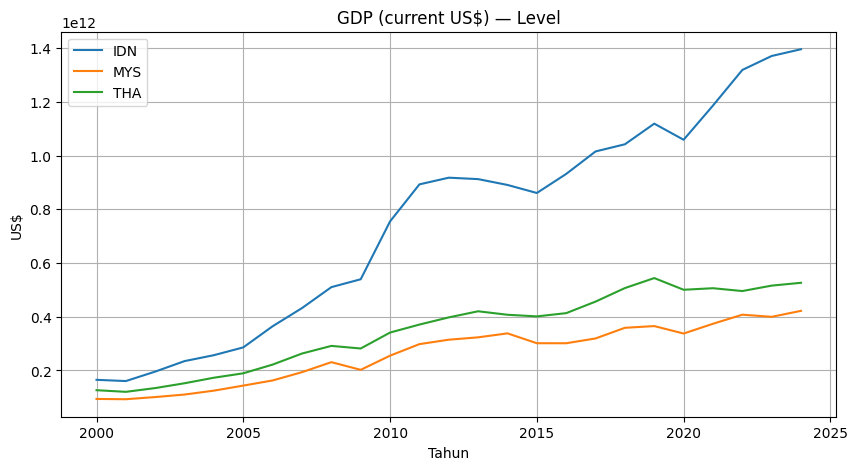

In [13]:
# Tren GDP (line) — semua negara
plt.figure(figsize=(10,5))
for code in wide.columns:
    plt.plot(wide.index, wide[code], label=code)
plt.title("GDP (current US$) — Level")
plt.xlabel("Tahun")
plt.ylabel("US$")
plt.legend()
plt.grid(True)
plt.show()


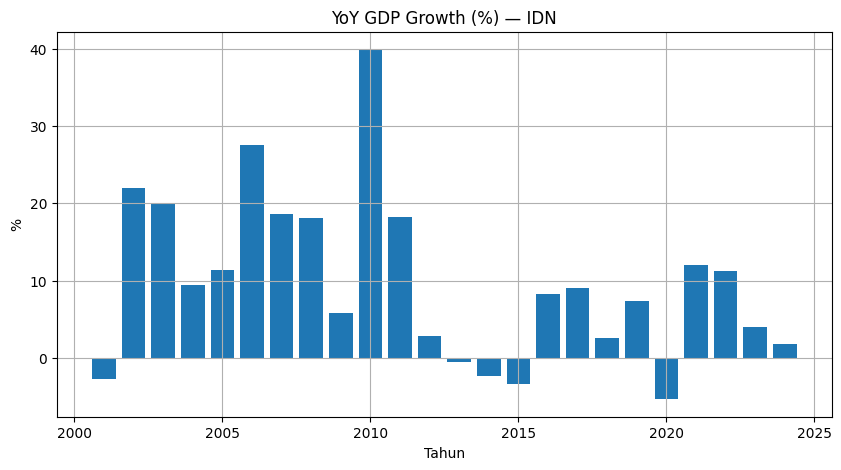

In [14]:
# YoY Growth (%) — bar untuk 1 negara contoh (ubah 'IDN' jika perlu)
kode_contoh = "IDN"
plt.figure(figsize=(10,5))
plt.bar(yoy.index, yoy[kode_contoh].values)
plt.title(f"YoY GDP Growth (%) — {kode_contoh}")
plt.xlabel("Tahun")
plt.ylabel("%")
plt.grid(True)
plt.show()


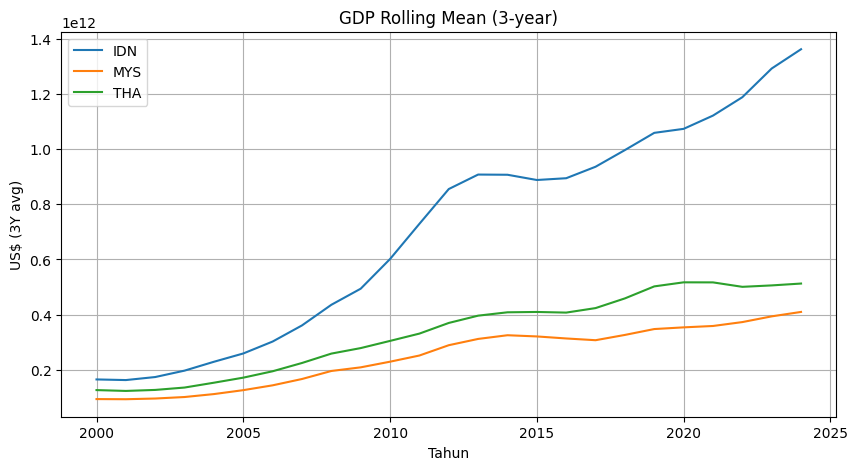

In [15]:
# Rolling Mean 3 tahun — smoothing tren
plt.figure(figsize=(10,5))
for code in roll3.columns:
    plt.plot(roll3.index, roll3[code], label=code)
plt.title("GDP Rolling Mean (3-year)")
plt.xlabel("Tahun")
plt.ylabel("US$ (3Y avg)")
plt.legend()
plt.grid(True)
plt.show()


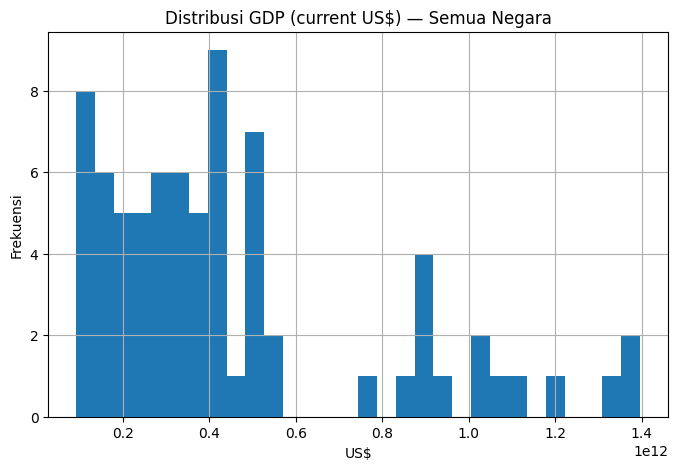

In [16]:
# Distribusi nilai GDP (histogram) — gabungan semua negara
vals = wide.values.flatten()
vals = vals[~np.isnan(vals)]
plt.figure(figsize=(8,5))
plt.hist(vals, bins=30)
plt.title("Distribusi GDP (current US$) — Semua Negara")
plt.xlabel("US$")
plt.ylabel("Frekuensi")
plt.grid(True)
plt.show()


/tmp/ipython-input-3625062672.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([wide[c].dropna().values for c in wide.columns], labels=wide.columns)


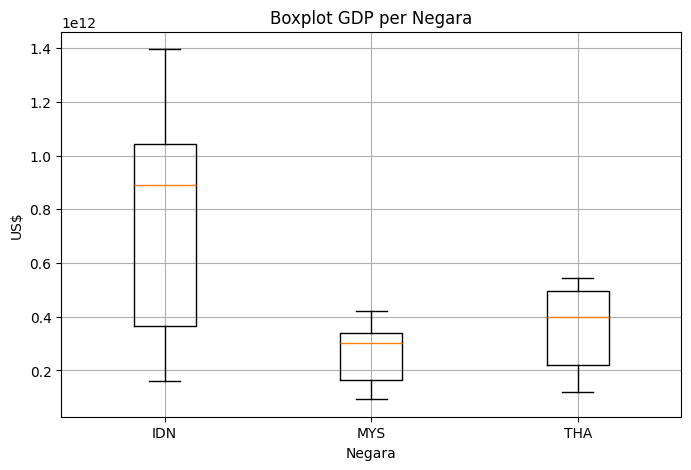

In [17]:
# Plot 5: Boxplot per negara (sebaran level GDP)
plt.figure(figsize=(8,5))
plt.boxplot([wide[c].dropna().values for c in wide.columns], labels=wide.columns)
plt.title("Boxplot GDP per Negara")
plt.xlabel("Negara")
plt.ylabel("US$")
plt.grid(True)
plt.show()


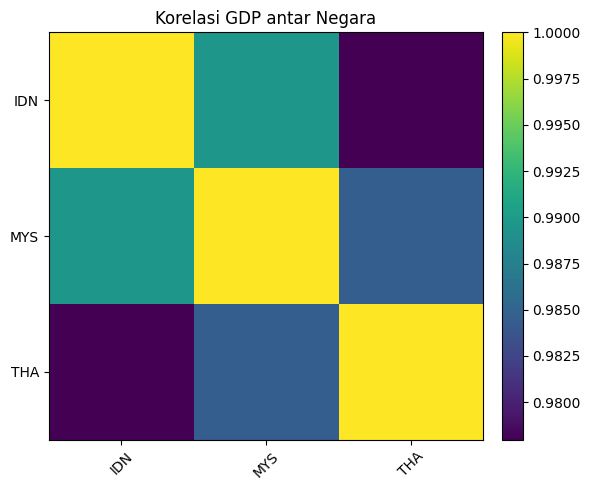

In [18]:
# Korelasi lintas negara (berdasarkan level GDP tahunan yang sejajar)
corr = wide.corr(min_periods=5)

plt.figure(figsize=(6,5))
im = plt.imshow(corr, aspect="auto")
plt.title("Korelasi GDP antar Negara")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
